In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from obspy.io.segy.segy import _read_segy
import matplotlib.ticker as ticker
from scipy.interpolate import griddata

In [3]:
dfs = pd.read_excel('../data/GravPlot.xlsx', sheet_name=None)

# Access individual sheets
df1 = dfs['Group 5']
df2 = dfs['Group 1']

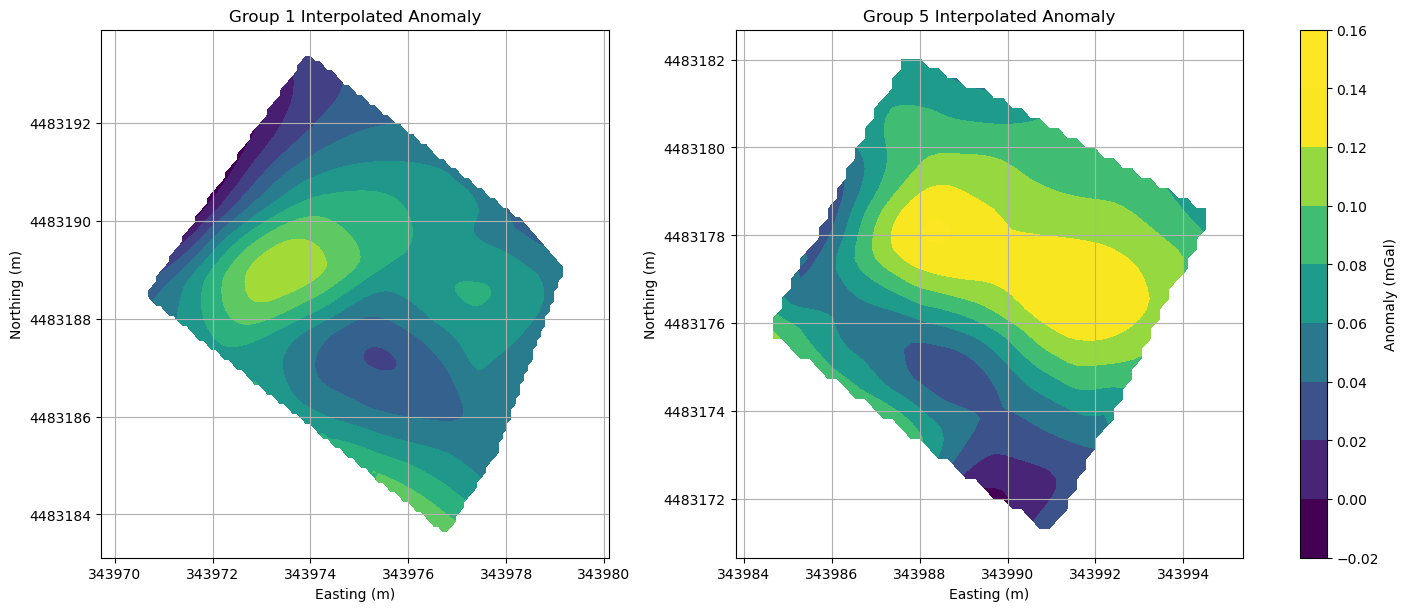

In [5]:
# Get global min and max for color scale
z_all = pd.concat([df1["new_anomaly (mGal)"], df2["new_anomaly (mGal)"]])
vmin = z_all.min()
vmax = z_all.max()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# First plot: df2 (Group 1 goes on the left)
x2 = df2['Easting (m)']
y2 = df2['Northing (m)']
z2 = df2['new_anomaly (mGal)']
xi2 = np.linspace(x2.min(), x2.max(), 100)
yi2 = np.linspace(y2.min(), y2.max(), 100)
xi2, yi2 = np.meshgrid(xi2, yi2)
zi2 = griddata((x2, y2), z2, (xi2, yi2), method='cubic')

c1 = axs[0].contourf(xi2, yi2, zi2, levels=8, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title("Group 1 Interpolated Anomaly")
axs[0].set_xlabel("Easting (m)")
axs[0].set_ylabel("Northing (m)")
axs[0].axis('equal')
axs[0].grid(True)
axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.0f}"))

# Second plot: df1 (Group 5 goes on the right)
x1 = df1['Easting (m)']
y1 = df1['Northing (m)']
z1 = df1['new_anomaly (mGal)']
xi1 = np.linspace(x1.min(), x1.max(), 50)
yi1 = np.linspace(y1.min(), y1.max(), 50)
xi1, yi1 = np.meshgrid(xi1, yi1)
zi1 = griddata((x1, y1), z1, (xi1, yi1), method='cubic')

c2 = axs[1].contourf(xi1, yi1, zi1, levels=8, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title("Group 5 Interpolated Anomaly")
axs[1].set_xlabel("Easting (m)")
axs[1].set_ylabel("Northing (m)")
axs[1].axis('equal')
axs[1].grid(True)
axs[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.0f}"))

# Shared colorbar (using the second plot handle)
cbar = fig.colorbar(c2, ax=axs, location='right', label='Anomaly (mGal)')

plt.show()
